In [1]:
using OrdinaryDiffEq, ParameterizedFunctions
using Optim, LsqFit 
using Plots, StatsPlots, LaTeXStrings
using DelimitedFiles, DataFrames
using Statistics
using Printf

In [2]:
ENV["COLUMNS"]=120
figdir = "figures/";

In [3]:
include("VirusLoadCurve.jl")
using .VirusLoadCurve

# Viral load data fitting



## Data set



In [4]:
filename = "../../data/Kennedy2014/figure3.csv"
temp = readdlm(filename, ',', Float64, '\n', header=true)
DATA = DataFrame(temp[1], Symbol.(temp[2][:]))

9×4 DataFrame
 Row │ t         Control   LowIgE   HighIgE 
     │ Float64  Float64   Float64  Float64  
─────┼──────────────────────────────────────
   1 │     0.0   0.01042  0.0       0.0
   2 │     1.0   2.01042  1.78125   1.71875
   3 │     2.0   4.07292  4.58333   3.5625
   4 │     3.0   4.88542  4.77083   3.96875
   5 │     4.0   4.36458  4.67708   4.07292
   6 │     7.0   3.47917  3.72917   3.91667
   7 │    10.0   2.76042  3.34375   2.64583
   8 │    14.0   3.0625   1.97917   2.34375
   9 │    21.0   2.20833  1.51042   1.89583

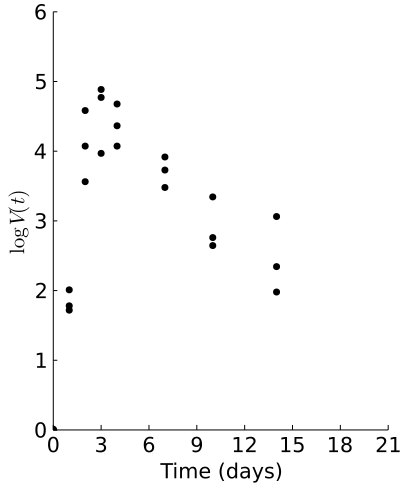

In [5]:
vlims = (0., 6)
plt = plot(legend=:none, ylims=vlims)
tdata = DATA.t
for k ∈ 2:4
    vdata = Array(DATA[:, k])
    data = VirusLoadCurve.VirusLoadData(tdata, vdata)
    plot!(plt, data, size = (400, 500), color=:black)
end
display(plt)

## Fitting the standard virus load function to each individual in all groups (nasal swab)

Consider a virus load function with three main phases given by

$$V(t)=v_1(t)v_2(t)v_3(t),$$

where $v _1$ describes the initial growth phase between $a _1$ and $a _2$ , $v _2$ the intermediate slow decay
phase between $a _2$ and $b _1$, and $v _3$ the final decay phase between $b _1$ and $b _2$. These functions are given as sigmoid and exponential functions, respectively

$$
\begin{aligned}
v_1(t) & = 1 + \frac{V_{\max} - 1}{2} \left[ \tanh \left( \frac{6}{a_2 - a_1} \left( t - \frac{a_1 + a_2}{2} \right) \right) - \tanh  \left( -3\frac{a_2 + a_1}{a_2 - a_1} \right) \right] \\
v_2(t) & = (1 - H(t - a_2)) + H(t - a_2)e^{-\alpha(t - a_2)} \\
v_3(t) & = 1 - \frac{1 - V_{\min}}{2} \left[ \tanh \left( \frac{6}{b_2 - b_1} \left( t - \frac{b_1 + b_2}{2} \right) \right) - \tanh  \left( -3\frac{b_2 + b_1}{b_2 - b_1} \right) \right],
\end{aligned}
$$

where $H(t)$ denotes the Heaviside function.

In [6]:
results = []
tdata = DATA.t
for k ∈ 2:4
    vdata = Array(DATA[:, k])
    data = VirusLoadCurve.VirusLoadData(tdata, vdata)
    resultVLF = VirusLoadCurve.fitVLF(data)
    push!(results, resultVLF)
end

Fitting the VLF to data 100%|███████████████████████████| Time: 0:01:29
Finding possible parameter values 100%|█████████████████| Time: 0:00:08


Number of possible parameters found: 107760 (out of 1000000 testted)


Fitting the VLF to data 100%|███████████████████████████| Time: 0:01:32
Finding possible parameter values 100%|█████████████████| Time: 0:00:08


Number of possible parameters found: 13794 (out of 1000000 testted)


Fitting the VLF to data 100%|███████████████████████████| Time: 0:01:06
Finding possible parameter values 100%|█████████████████| Time: 0:00:08


Number of possible parameters found: 112913 (out of 1000000 testted)


In [7]:
using JLD2, FileIO
# save("Kennedy2014Results.jld2", Dict("results" => results))
results = load("Kennedy2014Results.jld2", "results");

In [14]:
io = IOBuffer(append=true)
function param_extrema(result)
    param_array = result.param_array
    param = result.fit.param
    if length(param_array)==0 return (param, param) end
    array = map(x -> map(y -> y[x], param_array), 1:length(param_array[1]))
    param_lower = map(minimum, array)
    param_upper = map(maximum, array)
    return (param_lower, param_upper)
end
print(io, @sprintf "\nData & \$\\log V_{\\max}\$ & \$a_1\$ & \$a_2\$ & \$\\alpha\$ & \$b_1\$ & \$b_2\$ & RSS & \\lambda \\\\ \n")
function VLFResultsLatex(dataname, result)
    print(io, @sprintf "%s & " dataname)
#     print(io, @sprintf "%.2f \$\\cdot 10^{%d}\$ & " 10^rem(result.fit.param[6], 1) floor(result.fit.param[6]))
    print(io, @sprintf "%.2f & " result.fit.param[6])
    print(io, @sprintf "%.2f & " result.fit.param[1])
    print(io, @sprintf "%.2f & " result.fit.param[2])
    print(io, @sprintf "%.2f & " result.fit.param[5])
    print(io, @sprintf "%.2f & " result.fit.param[3])
    print(io, @sprintf "%.2f & " result.fit.param[4])
    print(io, @sprintf "%.3f & " sum(abs2, result.fit.resid))
    print(io, @sprintf "%.2f \\\\ \n" 5.2/(result.fit.param[2] - result.fit.param[1]))
    lower, upper = param_extrema(result)
    print(io, @sprintf "  & ")
#     print(io, @sprintf "(%.2f \$\\cdot 10^{%d}\$, %.2f \$\\cdot 10^{%d}\$) & " 10^rem(lower[6], 1) floor(lower[6]) 10^rem(upper[6], 1) floor(upper[6]))
    print(io, @sprintf "(%.2f, %.2f) & " lower[6] upper[6])
    print(io, @sprintf "(%.2f, %.2f) & " lower[1] upper[1])
    print(io, @sprintf "(%.2f, %.2f) & " lower[2] upper[2])
    print(io, @sprintf "(%.2f, %.2f) & " lower[5] upper[5])
    print(io, @sprintf "(%.2f, %.2f) & " lower[3] upper[3])
    print(io, @sprintf "(%.2f, %.2f) & " lower[4] upper[4])
    print(io, @sprintf "\$\\leq\$ %.3f & -- \\\\ \n" (1.0 - 2/(length(result.data.t)-4)*log(0.15))*sum(abs2, result.fit.resid))
end

VLFResultsLatex (generic function with 1 method)

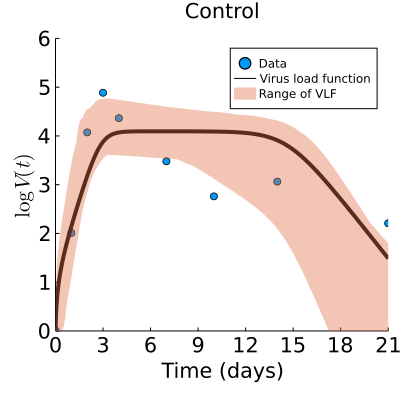

Control: 
RSS = 5.30592e+00
a₁ = 0.338770282115201, CI=(8.012103148707928e-5, 1.364638622079037)
a₂ = 5.299330896755708, CI=(1.4667419414985998, 6.720152076056265)
b₁ = 8.333570271706565, CI=(3.9295781512050194, 12.377825335055292)
b₂ = 21.0, CI=(17.770740210803023, 21.0)
α = 1.0000000050247593e-8, CI=(1.0000000050247593e-8, 0.5640333109783955)
logVmax = 4.095729140682006, CI=(3.478832181711342, 4.8930619807337274)


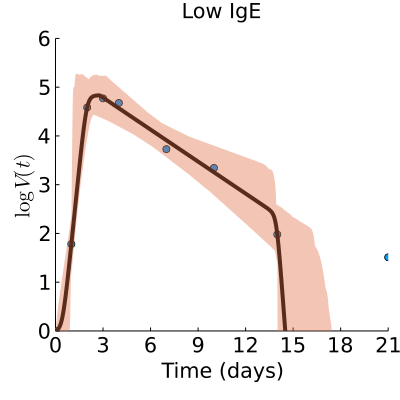




Low IgE: 
RSS = 2.33464e+00
a₁ = 1.1428479515197199, CI=(0.8677192777296714, 1.3738891481251123)
a₂ = 2.787970274006371, CI=(1.0351499775506836, 3.652305849664142)
b₁ = 13.328857446503882, CI=(9.691002043228202, 17.513160252050103)
b₂ = 14.583953525650267, CI=(14.023738834290453, 18.777676962404616)
α = 0.5037475965273308, CI=(0.2502451598648673, 0.7374376375080783)
logVmax = 4.8329821879950945, CI=(4.431958900753953, 5.312863006610967)


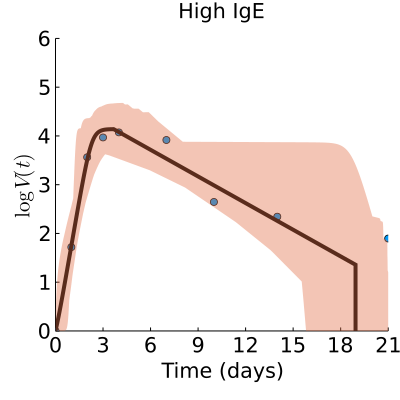




High IgE: 
RSS = 3.89210e+00
a₁ = 0.88724841752667, CI=(1.0366820572427216e-5, 1.3675602986858388)
a₂ = 3.6700164699598594, CI=(1.0228956358142915, 6.664865725073831)
b₁ = 18.93981071346512, CI=(14.638511077694798, 20.999546001025728)
b₂ = 18.93981071346512, CI=(16.042206177759127, 20.99997791008667)
α = 0.4195385862847316, CI=(0.0015750550909085503, 0.7814892310613977)
logVmax = 4.140245570179188, CI=(3.3703087300702723, 4.688131854977001)




Data & $\log V_{\max}$ & $a_1$ & $a_2$ & $\alpha$ & $b_1$ & $b_2$ & RSS & \lambda \\ 
Control & 4.10 & 0.34 & 5.30 & 0.00 & 8.33 & 21.00 & 5.306 & 1.05 \\ 
  & (3.48, 4.89) & (0.00, 1.36) & (1.47, 6.72) & (0.00, 0.56) & (3.93, 12.38) & (17.77, 21.00) & $\leq$ 9.332 & -- \\ 
Low IgE & 4.83 & 1.14 & 2.79 & 0.50 & 13.33 & 14.58 & 2.335 & 3.16 \\ 
  & (4.43, 5.31) & (0.87, 1.37) & (1.04, 3.65) & (0.25, 0.74) & (9.69, 17.51) & (14.02, 18.78) & $\leq$ 4.106 & -- \\ 
High IgE & 4.14 & 0.89 & 3.67 & 0.42 & 18.94 & 18.94 & 3.892 & 1.87 \\ 
  & (3.37, 

In [15]:
cases = ["Control", "Low IgE", "High IgE"]
filename = "Kennedy-2014-"
for (resultVLF, case, k) ∈ zip(results, cases, 1:length(cases))
    println(case*": ")
    summary(resultVLF)
    VLFResultsLatex(case, resultVLF)
    pt = plot(resultVLF.data, size = (400, 400))
    if k > 1
        plot!(pt, legend=:none)
    end
    plot!(pt, resultVLF)
    ylims!(pt, vlims)
    title!(pt, case)
    savefig(figdir*filename*replace(case, " " => "-")*".png")
    savefig(figdir*filename*replace(case, " " => "-")*".pdf")
    display(pt)
    println("\n\n")
end
print(read(io, String))

In [16]:
function Boxplots(results)
    ndata = length(results)
    params = []
    for resultVLF ∈ results
        params = vcat(params, resultVLF.fit.param)
    end
    params = reshape(params, (6, ndata))
    param_names = results[1].names
    pt1 = plot(yaxis=("Time (days)", extrema(params[1:4, :]) .+ (-0.5, 0.5), font(14)), 
        xaxis=("Parameter", font(14)), 
        grid=false, legend=false, left_margin = 5Plots.mm, right_margin = 16Plots.mm)
    [boxplot!(pt1, repeat([param_names[i]], ndata), params[i, :], fillalpha=0.7, lw=2, color=1) for i = 1:4]
    [dotplot!(pt1, repeat([param_names[i]], ndata), params[i, :], marker=(:black, stroke(0))) for i = 1:4]
    pt2 = twinx()
    plot!(pt2, yaxis=("Decay rate (1/days)", extrema(params[5, :]) .+ (-0.2, 0.2), font(14)), 
        xaxis=("", font(14)), 
        grid=false, legend=false, left_margin = 5Plots.mm, right_margin = 16Plots.mm)
    boxplot!(pt2, repeat([param_names[5]], ndata), params[5, :], fillalpha=0.7, lw=2, color=2)
    dotplot!(pt2, repeat([param_names[5]], ndata), params[5, :], marker=(:black, stroke(0)))
    pt1
end

Boxplots (generic function with 1 method)

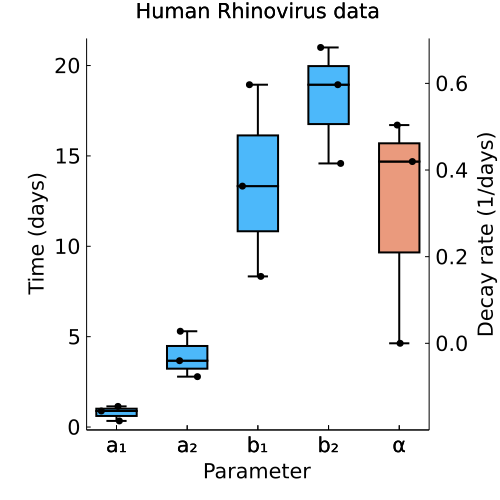

In [17]:
text_data = "Human Rhinovirus data"
text_file = "Kennedy2014-Boxplot"
pt = Boxplots(results)
plot!(title = text_data, size=(500, 500))
savefig(figdir*text_file*".pdf")
savefig(figdir*text_file*".png")
display(pt)